<a href="https://colab.research.google.com/github/pasqualemocerino/AILabProj-FaceRecognition/blob/main/FaceRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Face Recognition
Face Recogniton is a form of biometrics, the science which deals with the automated recognition of individuals based on biological and behavioral characteristics. It is included in physiological or static biometrics, based on data derived from the measurement of a part of a person's anatomy.
The main purpose is the authentication of the subject, which follows identification and is based on proving the previously declared identity.

We will later discuss about the advantages and disadvantages of this mechanism, analysing the requirements for an ideal biometric identifier: Universality, Uniqueness, Performance, Collectability, Acceptability.

Face Recognition or Face Identification is: given the picture of the face of an unknown person, identify the name of the person by referring to a gallery of previously seen pictures of identified persons.


###About the dataset
Labeled Faces in the Wild (LFW) is an image dataset containing face photographs, collected especially for studying the problem of unconstrained face recognition. It includes over 13,000 images of faces collected from across the web. Here are key aspects of these images.

Each face in this data set was labeled with the person’s name in the image.
1680 of the photographed persons distinctly appear in two or more photos in the data set.
The faces in these images were detected by the Viola-Jones face detector (Paul Viola and Michael Jones, 2001).

LFW includes four different sets of images, including the original and three types of aligned images that can be used to test algorithms under different conditions. For alignment, the dataset uses funneled images (ICCV 2007), LFW-a, and deep funneled images (NIPS 2012). Deep funneled and LFW-a images produce superior results for most face verification algorithms over the funneled images and the original images.

Face Recognition is a task typically performed on the output of a model trained to perform Face Detection. The most popular model for Face Detection is called Viola-Jones and is implemented in the OpenCV library. The LFW faces were extracted by this face detector from various online websites.

###Purpose
Our first purpose is to create a pretrained model in order to achieve an identity-based accurate classification of a dataset of well-known faces. Then we will make the neural network recognize further faces using new measurements linked to proper identity labels. A final objective could be to make an app which recognize human faces after collecting data.

#FaceNet
FaceNet is a deep neural network used for extracting features from an image of a person’s face. It was published in 2015 by Google researchers.

FaceNet takes an image of the person’s face as input and outputs a vector of 128 numbers which represent the most important features of a face. In machine learning, this vector is called embedding. Why embedding? Because all the important information from an image is embedded into this vector. Basically, FaceNet takes a person’s face and compresses it into a vector of 128 numbers. Ideally, embeddings of similar faces are also similar.

FaceNet learns in the following way:

1. Randomly selects an anchor image.
2. Randomly selects an image of the same person as the anchor image (positive example).
3. Randomly selects an image of a person different than the anchor image (negative example).
4. Adjusts the FaceNet network parameters so that the positive example is closer to the anchor than the negative example.

We repeat these steps until there are no more changes to be done, so all the faces of the same person are close to each other and far from others.

This method of learning with anchor, positive and negative examples is called triplet loss.

The classification step could be done by calculating the embedding distances between a new face and known faces, but that approach is too computationally and memory expensive (this approach is called k-NN). Instead, we decided to use the Softmax classifier which memorises boundaries between people which is much more efficient.

#Schedule
1. Pre-processing — a method used to take a set of images and convert them all to a uniform format — in our case, a square image containing just a person’s face. A uniform dataset is useful for decreasing variance when training as we have limited computational resources when using the Edge TPU.
2. Embedding — a process, fundamental to the way FaceNet works, which learns representations of faces in a multidimensional space where distance corresponds to a measure of face similarity.
3. Classification — the final step which uses information given by the embedding process to separate distinct faces.

##1. Pre-processing


###1.1. Basic steps.

In [1]:
%matplotlib inline

In [2]:
import os
import torch 
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [57]:
#Training hyperparameters
BATCH_SIZE = 16

#Setting the device to train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Loading the dataset
print("[INFO] Loading the LFW dataset...")
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((160,160)),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = datasets.LFWPeople(root='./data', split='train', 
                          transform = transform, download=True)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
print("[INFO] Trainset loaded:")
print(trainset)
testset = datasets.LFWPeople(root='./data', split='test',
                          transform = transform, download=True)
testloader = DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)
print("[INFO] Testset loaded:")
print(testset)

[INFO] Loading the LFW dataset...
Files already downloaded and verified
[INFO] Trainset loaded:
Dataset LFWPeople
    Number of datapoints: 9525
    Root location: ./data/lfw-py
    Alignment: funneled
    Split: train
    Classes (identities): 5749
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(160, 160), interpolation=bilinear, max_size=None, antialias=None)
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Files already downloaded and verified
[INFO] Testset loaded:
Dataset LFWPeople
    Number of datapoints: 3708
    Root location: ./data/lfw-py
    Alignment: funneled
    Split: test
    Classes (identities): 5749
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(160, 160), interpolation=bilinear, max_size=None, antialias=None)
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


Display a single batch of images from trainset. The choice to split between trainset and testset is only for modularity: we will later test the model on the whole dataset.


In [4]:
import matplotlib.pyplot as plt
import numpy as np

In [5]:
def imshow(img):
  # Unnormalizing
  img = img/2 + 0.5 
  # Plotting
  plt.imshow(np.transpose(img.numpy(), (1,2,0)))

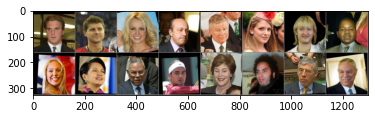

In [64]:
trainiter = iter(trainloader)
images, labels = trainiter.next()

imshow(torchvision.utils.make_grid(images))

###1.2. MTCNN
One face landmark detector that has proven to work very well for face alignment in this setting is the Multi-task CNN (MTCNN).

####mtcnn

A first possibility is to use the package mtcnn.

1. Initialization.

In [7]:
%pip install mtcnn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 14.9 MB/s 


In [33]:
import cv2
import mtcnn
from mtcnn.mtcnn import MTCNN

image_path = "/content/data/lfw-py/lfw_funneled/Bill_Clinton/Bill_Clinton_0004.jpg"
print("Versione di MTCNN:", mtcnn.__version__)

Versione di MTCNN: 0.1.0


2. Define a method to detect face in an image using MTCNN, returning bounding boxes.

In [9]:
#Defining a face detector
def face_detector(image):
  detector = MTCNN()
  bboxes = detector.detect_faces(image)
  return bboxes

3.  Define a method to draw bounding box around the face in an image.

In [10]:
#Drawing function
def draw_bounding_boxes(image, bboxes):
    for box in bboxes:
        x, y, w, h = box['box']
        cv2.rectangle(image, (x, y), (x+w,y+h), (0,255,0), 2)

4. Define a method to mark keypoints on face.

In [11]:
#Keypoints mark on face
def mark_keypoints(image, keypoints):
  cv2.circle(image, (keypoints), 1, (0,255,0), 2)

5. Test with an image to detect a face.

In [12]:
#Image processing
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

bboxes = face_detector(image)
print("Output of MTCNN detector: \n", bboxes)

Output of MTCNN detector: 
 [{'box': [70, 55, 107, 143], 'confidence': 0.9999871253967285, 'keypoints': {'left_eye': (91, 109), 'right_eye': (135, 110), 'nose': (106, 136), 'mouth_left': (96, 157), 'mouth_right': (135, 159)}}]


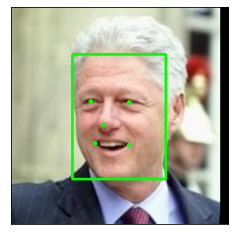

In [13]:
# Drawing bounding box around face and marking keypoints
draw_bounding_boxes(image, bboxes)
mark_keypoints(image, bboxes[0]['keypoints']['left_eye'])
mark_keypoints(image, bboxes[0]['keypoints']['right_eye'])
mark_keypoints(image, bboxes[0]['keypoints']['nose'])
mark_keypoints(image, bboxes[0]['keypoints']['mouth_left'])
mark_keypoints(image, bboxes[0]['keypoints']['mouth_right'])

# Display the image
plt.imshow(image)
plt.xticks([])
plt.yticks([])
plt.show()

In [14]:
def crop_face(image, bboxes):
    for box in bboxes:
        x, y, w, h = box['box']
        return image[y:y+h, x:x+w]

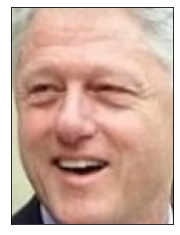

In [15]:
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

face = crop_face(image,bboxes)
plt.imshow(face)
plt.xticks([])
plt.yticks([])
plt.show()

However, mtcnn is good to work an a single image, but works very slowly on batches. The output should also be squared, with equal width and height. Let's try another approach.

####facenet-pytorch
A batched face detection of a MTCNN is implemented in the facenet-pytorch package.

In [16]:
%pip install facenet-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 15.4 MB/s 


#####Verify how it works on a single image.

In [17]:
from PIL import Image
from facenet_pytorch import MTCNN, training

In [18]:
# Face detector
mtcnn = MTCNN(margin=15, 
              select_largest=False, 
              post_process=False, 
              device=device)

# Processing an image
img = Image.open("/content/data/lfw-py/lfw_funneled/Bill_Clinton/Bill_Clinton_0004.jpg")

# Detect face, returning cropped and prewhitened image tensor
face = mtcnn(img)

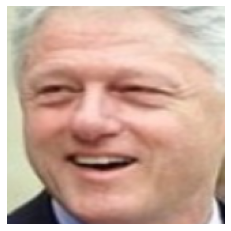

In [19]:
# Visualize
plt.imshow(face.permute(1, 2, 0).int().numpy())
plt.axis('off');
plt.show()

#####Now we works with batched detection.

######1. Set parameters.

In [20]:
data_dir = '/content/data/lfw-py/lfw_funneled'
pairs_path = '/content/data/lfw-py/lfw_funneled/pairs.txt'

EPOCHS = 15

In [21]:
print('Running on device: {}'.format(device))

Running on device: cuda


######2. Build the MTCNN.

In [22]:
mtcnn = MTCNN(
    image_size=160,
    margin=15,
    device=device,
    selection_method='center_weighted_size'
)

######3. Define the data loader.

In [23]:
# Data loader for the input set of images
input_loader = datasets.ImageFolder(root=data_dir, transform=None)

######4. Overwrite class labels with path used to save output.

In [24]:
# Overwriting class labels with path
input_loader.samples = [(p, p) for p, _ in input_loader.samples]

img_loader = DataLoader(input_loader, 
                    batch_size= BATCH_SIZE, 
                    num_workers= WORKERS,
                    collate_fn=training.collate_pil
          )

######5. Build a new folder containing cropped images of faces. Now we works on batches.

In [28]:
# (Optional) Command to ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [30]:
face_paths = []
box_probs = []

print("[INFO] Processing...")
for i, (x, b_paths) in enumerate(img_loader):
    faces = [p.replace(data_dir, data_dir + '_faces') for p in b_paths]
    mtcnn(x, save_path=faces)
    face_paths.extend(faces)
    print('\rBatch {} of {}'.format(i+1, len(img_loader)), end='')
print("\n[INFO] Process ended.")

[INFO] Processing...
Batch 828 of 828
[INFO] Process ended.


######6. Remove MTCNN to reduce GPU memory usage and empty CUDA cache.

In [34]:
del mtcnn
torch.cuda.empty_cache()

##2. Embedding

We will give the output faces of MTCNN as inputs to Inception net, in order to obtain embeddings of faces.

###2.1 Prepare input for Inception net

In [35]:
from torch.utils.data import SubsetRandomSampler, SequentialSampler
from facenet_pytorch import InceptionResnetV1, fixed_image_standardization, extract_face

In [38]:
# Dataset and dataloader from output faces of MTCNN

transform = transforms.Compose([
  np.float32,
  transforms.ToTensor(),
  fixed_image_standardization
])

dataset = datasets.ImageFolder(root=data_dir + '_faces', transform=transform)

face_loader = DataLoader(
    dataset,
    num_workers = WORKERS,
    batch_size = BATCH_SIZE,
    sampler = SequentialSampler(dataset)
)

###2.2 Load a pretrained net for embedding

We load a model trained on large dataset VGGFace2.

In [37]:
resnet = InceptionResnetV1(
    classify=False,
    pretrained='vggface2'
).to(device).eval()

  0%|          | 0.00/107M [00:00<?, ?B/s]

###2.3 Calculate embeddings 

We are going to calculate 512-bit embeddings, instead of the 128-bit embeddngs described in FaceNet paper.

In [58]:
# Arrays of 13233 elements each one (number of elements of dataset)
classes = [] # Labels in the range [0,5748] (5749 possible identities)
embeddings = [] # 512-bit elements

with torch.no_grad():
  for faces, labels in face_loader:
    faces = faces.to(device)

    #Batch embeddings
    b_embd = resnet(faces)
    b_embd = b_embd.to('cpu').numpy()
    classes.extend(labels.numpy())
    embeddings.extend(b_embd)

###2.4 Save embeddings to relative paths

In [59]:
embeddings_dict = dict(zip(face_paths,embeddings))

##3. Classification

###3.1 Importing necessary dependecies

In [63]:
import math
from sklearn.model_selection import KFold
from scipy import interpolate

###3.2 Defining a metric